In [20]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

import statsmodels.formula.api as smf

from imblearn.under_sampling import RandomUnderSampler

In [21]:
def my_import():
    
    # Still including terror attacks...
    
    df = pd.read_csv("interpolated_df.csv", index_col= 0)

    ucdp = pd.read_csv("/home/polichinel/Dropbox/KU/9.semester/friopgave/data/upsala/ged181.csv")# the error is not importent as you do not use that feature 
    ucdp =  ucdp[ucdp['gwnob'].isna()] # only conflicts NOT between to stats

    ucdp_agg = ucdp.groupby(by = ['country_id','year'])[['best']].sum().reset_index()

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)
    
    # CCode and country_id should correspond but check GW 2013!

    cow_ucdp_agg = cow.merge(ucdp_agg, on = 'country_id', how = 'outer')

    cow = pd.read_csv("COW country codes.csv")
    cow.rename(columns={'CCode' : 'country_id', 'StateAbb' : 'country'}, inplace = True)

    cow_ucdp_agg = cow.merge(ucdp_agg, on = 'country_id', how = 'outer')

    df_cow_ucdp_agg = df.merge(cow_ucdp_agg, on = ['country', 'year'], how = 'left')
    df_cow_ucdp_agg['best'].fillna(0,inplace = True)
    
    df_cow_ucdp_agg_lean = df_cow_ucdp_agg[['best','indegree_norm','outdegree_norm','degree_norm','center','downgrading','slope_indegree','slope_outdegree']]
    
    return(df_cow_ucdp_agg_lean)

In [22]:
df = my_import()

/home/polichinel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [23]:
df.shape

(8101, 8)

In [24]:
df.dropna().shape # Why? Where?

(5928, 8)

In [25]:
df.dropna(inplace = True)

#y = df['best'].copy()

y = np.array(df['best'] > 0).astype('int') # y_dum
X = df[['indegree_norm','outdegree_norm','degree_norm','center','downgrading','slope_indegree','slope_outdegree']]

# X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_sample(X,y)

# X = X_resampled

# y = y_resampled


# Du skal nok ige havde lavet dig et test set...

In [26]:
y.sum()/y.shape

array([0.19787449])

In [27]:
time_start = time.time()

sfs_f = sfs(estimator = linear_model.LogisticRegression(), k_features= 'best', forward = True, verbose = 2, scoring = 'roc_auc', cv = 10, n_jobs = 6)

sfs_f = sfs_f.fit(X,y)


time_stop = time.time()
time_to_finish = time_stop - time_start

print('\nminutes it took: {}\n'. format(time_to_finish/60))


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed:    0.2s finished

[2018-11-28 22:18:39] Features: 1/7 -- score: 0.6036502587379562[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.2s finished

[2018-11-28 22:18:39] Features: 2/7 -- score: 0.6152940922429038[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished

[2018-11-28 22:18:40] Features: 3/7 -- score: 0.6189433705502604[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished

[2018-11-28 22:18:40] Features: 4/7 -- score: 0.6172890464747394[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished

[2018-11-28 22:18:41] Features: 5/7 -- score: 0.6060917199561268[Para


minutes it took: 0.04123289982477824



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished

[2018-11-28 22:18:41] Features: 7/7 -- score: 0.5273819274135694

In [28]:

def first_best(selector = sfs_f):

    result = 0

    for i in np.arange(1,len(selector.k_feature_idx_)+1):

        if selector.get_metric_dict()[i]['avg_score'] > result:

            result = selector.get_metric_dict()[i]['avg_score']
            feature_index = selector.get_metric_dict()[i]['feature_idx']
            feature_names = selector.get_metric_dict()[i]['feature_names']
            n_features = len(feature_index)

        else:
            break
     
    return([n_features,result,feature_index,feature_names])

In [29]:
best_set = first_best()
best_set

[3,
 0.6189433705502604,
 (0, 4, 5),
 ('indegree_norm', 'downgrading', 'slope_indegree')]

In [30]:
# # Hvis du skal bruge det skal du lave dit eget plt...
# plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
# plt.vlines(best_set[0], 0, 1, 'red', 'dashed', alpha = 0.5)


# plt.show()

# you compare to GDP per capita?

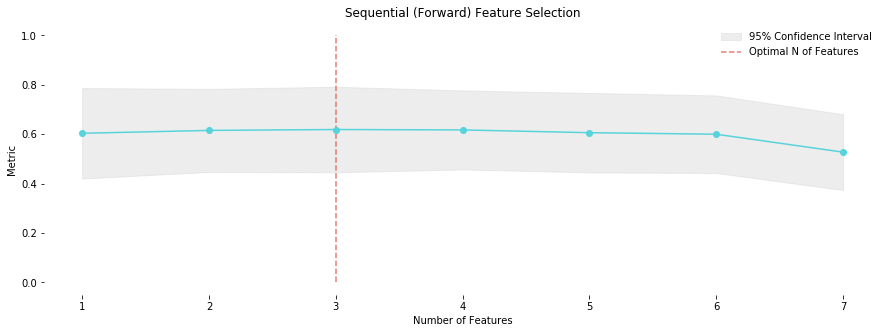

In [31]:
def plot_seq_fs():

    list_of_means = []
    list_of_std_dev = []
    list_of_n = []

    for i in np.arange(1,len(sfs_f.get_metric_dict())+1):

        list_of_means.append(sfs_f.get_metric_dict()[i]['cv_scores'].mean())
        list_of_std_dev.append(sfs_f.get_metric_dict()[i]['std_dev']) # but why is it not 2*std_err?
        list_of_n.append(i)

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)    

    plt.figure(figsize=[15,5])    

    x = np.array(list_of_n)
    y = np.array(list_of_means)

    y_upper = y + np.array(list_of_std_dev) # * 2) 
    y_lower = y - np.array(list_of_std_dev) #* 2)

    plt.plot(x,y, '-o' ,color = colors[1])
    #plt.plot(x, y_upper, x, y_lower, color=colors[1], alpha = 0.4)

    plt.fill_between(x, y_lower, y_upper, color='lightgrey', alpha = 0.4, label = '95% Confidence Interval')

    plt.vlines(best_set[0], 0, 1, colors[0], 'dashed', alpha = 0.8, label = 'Optimal N of Features')

    plt.ylabel('Metric')
    plt.xlabel('Number of Features')
    plt.title('Sequential (Forward) Feature Selection')

    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)
    plt.show()
    
plot_seq_fs()

In [54]:
x1 = X['indegree_norm']
x2 = X[['indegree_norm','downgrading']]
x3 = X[['indegree_norm','downgrading','slope_indegree']]

results1 = smf.Logit(y, x1).fit() #but you need of to include country and year FE.. But then you are there.
results2 = smf.Logit(y, x2).fit() #but you need of to include country and year FE.. But then you are there.
results3 = smf.Logit(y, x3).fit() #but you need of to include country and year FE.. But then you are there.

Optimization terminated successfully.
         Current function value: 0.592909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590181
         Iterations 6


In [56]:
print(results1.summary2())
print(results2.summary2())
print(results3.summary2())

                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: y                Pseudo R-squared: -0.192   
Date:               2018-11-28 22:24 AIC:              7031.5242
No. Observations:   5928             BIC:              7038.2117
Df Model:           0                Log-Likelihood:   -3514.8  
Df Residuals:       5927             LL-Null:          -2948.8  
Converged:          1.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
indegree_norm   -3.6719   0.1243 -29.5325 0.0000 -3.9156 -3.4282

                         Results: Logit
Model:              Logit            No. Iterations:   6.0000   
Dependent Variable: y                Pseudo R-squared: -0.191   
Date:               2018-11-28 22:24 AIC:              7026.3917
No. Obser